# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.preprocessing import LabelEncoder
import huggingface_hub

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Speech and Language Processing/chapter_4/valid_data_cleaned.csv'

test_data = pd.read_csv(file_path)
display(test_data)

,Unnamed: 0,id,text_in_author_style,author,avg_word_length,text_size,detected_language,cleaned_text
0,0,3835,من طفل في الخمسين\n\nعمري ما احتفلت أو حفلت بع...,يوسف إدريس,4.485623,1747,ar,من طفل في الخمسين\n\nعمري ما احتفلت أو حفلت بع...
1,1,3836,ذلك الزمن العام هو العداد العام الذي\n\nدام يع...,يوسف إدريس,4.578171,1922,ar,ذلك الزمن العام هو العداد العام الذي\n\nدام يع...
2,2,3837,مصر الغنية المثقفة المصنِّعة، والعرب\n\nوقد\n\...,يوسف إدريس,4.816770,1903,ar,مصر الغنية المثقفة المصنعة، والعرب\n\nوقد\n\nأ...
3,3,3838,ولأنها غريبة وراودتني فيها عن الناس وعن الحياة...,يوسف إدريس,4.733333,1747,ar,ولأنها غريبة وراودتني فيها عن الناس وعن الحياة...
4,4,3839,وليس ما ذكرته مرارة ولا ندمًا؛ فقد كان لا يمكن...,يوسف إدريس,4.537367,1580,ar,وليس ما ذكرته مرارة ولا ندما؛ فقد كان لا يمكن ...
...,...,...,...,...,...,...,...,...
4152,4152,28140,وعندما هاجموني\n\nصمدتُ لهم أولًا، ثم\n\nبدءوا...,ويليام شيكسبير,4.812689,1992,ar,وعندما هاجموني\n\nصمدت لهم أولا، ثم\n\nبدءوا ي...
4153,4153,28141,وتَدخُل بعد ذلك مركيزة دورسيت\n\n(الإشبينة الأ...,ويليام شيكسبير,4.982456,1773,ar,وتدخل بعد ذلك مركيزة دورسيت\n\n(الإشبينة الأخر...
4154,4154,28142,ولن يرقُد هذا السلمُ عندما ترقُد رقدةَ\n\nالأب...,ويليام شيكسبير,4.974194,1923,ar,ولن يرقد هذا السلم عندما ترقد رقدة\n\nالأبد،\n...
4155,4155,28143,لم يكن المارك عملةً متداولة، ولكن مقدار من\n\n...,ويليام شيكسبير,5.000000,1938,ar,لم يكن المارك عملة متداولة، ولكن مقدار من\n\nا...


In [ ]:
test_data['input'] = test_data['cleaned_text']

# Encode labels
label_encoder = LabelEncoder()
test_data['label'] = label_encoder.fit_transform(test_data['author'])
num_labels = len(label_encoder.classes_)

test_dataset = Dataset.from_pandas(test_data[['input', 'label']])
test_dataset

Dataset({
    features: ['input', 'label'],
    num_rows: 4157
})

# Inference Function

In [ ]:
!pip install -qU transformers

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments

In [ ]:
def predict(model_name, dataset):
  """
  Generates predicted labels for a given model on a dataset.

  Args:
      model_name (str): The name of the pre-trained model to load from Hugging Face Hub.
      dataset (datasets.Dataset): The dataset to evaluate the model on. It should
                                  contain 'input' and 'label' columns.

  Returns:
      tuple: A tuple containing two numpy arrays:
          - y_true (numpy.ndarray): The true labels of the dataset.
          - y_pred (numpy.ndarray): The predicted labels from the model.
  """
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name)
  print(f"Model '{model_name}' loaded successfully!")

  tokenized_dataset = dataset.map(lambda sample: tokenizer(sample['input'], truncation=True, padding='max_length', max_length=512), batched=True)

  training_args = TrainingArguments(
      output_dir="./results",  # Specify an output directory
      report_to=[]  # Disable reporting to wandb
  )

  trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer)

  preds = trainer.predict(tokenized_dataset)
  y_true = preds.label_ids
  y_pred = preds.predictions.argmax(axis=-1)

  return y_true, y_pred

# Statistical Significance Test

Explanation of the statistical significance test using bootstrapping to compare two authorship identification models, Model A and Model B:

1.  **Original Difference (Effect Size)**
    $$\delta(x) = M(A, x) - M(B, x)$$
    - Metric $"M"$ is Macro F1 score.
    - $x$ is the original test dataset.
2.  **Hypotheses:**
    *   Null Hypothesis: Model A is not better than Model B $$H_0: \delta(x) \leq 0$$
    *   Alternative Hypothesis: Model A is better than Model B $$H_1: \delta(x) > 0$$

3.  **Bootstrapping:** Create virtual test sets by sampling with replacement from the original dataset ($x'$).
    - Note that unlike a standard bootstrap test where the expected value of  $\delta(X)$  under  $H_0$  is $0$, here the samples are drawn from a biased test set, so the distribution mean is not $0$.

4.  **p-value:**
    $$P(\delta (X) \geq 2\delta (x)|H_0 \text{ is true})$$
    - Calculate the difference in F1 scores $\delta(x')$ for each virtual set.
    - The p-value is the probability of observing a difference exceeding the the original difference $\delta(x)$ by $\delta(x)$ or more, assuming $H_0$ is true.

5.  **Conclusion:** If the p-value is below the significance threshold (e.g., 0.05), reject $H_0$ and conclude that Model A is statistically significantly better.

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_p_value(model_A, model_B, dataset, num_samples):
  """
  Calculates the p-value for the difference in F1 scores between two models using bootstrapping.

  Args:
      model_A (str): The name of the first pre-trained model on Hugging Face Hub.
      model_B (str): The name of the second pre-trained model on Hugging Face Hub.
      dataset (datasets.Dataset): The dataset to evaluate the models on. # x
      num_samples (int): The number of bootstrap samples to generate.

  Returns:
      float: The calculated p-value.
  """
  y_true, y_pred_model_A = predict(model_A, dataset)
  _, y_pred_model_B = predict(model_B, dataset)

  model_A_f1 = f1_score(y_true, y_pred_model_A, average='macro') # M(A,x)
  model_B_f1 = f1_score(y_true, y_pred_model_B, average='macro') # M(B,x)
  orig_diff = model_A_f1 - model_B_f1 # δ(x)
  print(f"\nOriginal difference in F1 scores = {orig_diff:.4f}")


  greater_total = 0
  sample_size = len(test_dataset)
  bootstrap_diffs = []
  for i in range(num_samples):

    bootstrap_indices = np.random.choice(sample_size, size=sample_size, replace=True)

    y_true_bootstrap = y_true[bootstrap_indices]
    y_pred_model_A_bootstrap = y_pred_model_A[bootstrap_indices]
    y_pred_model_B_bootstrap = y_pred_model_B[bootstrap_indices]

    model_A_f1_bootstrap = f1_score(y_true_bootstrap, y_pred_model_A_bootstrap, average='macro') # M(A, x′)
    model_B_f1_bootstrap = f1_score(y_true_bootstrap, y_pred_model_B_bootstrap, average='macro') # M(B, x′)
    bootstrap_diff = model_A_f1_bootstrap - model_B_f1_bootstrap # δ(x′)
    bootstrap_diffs.append(bootstrap_diff)

    if bootstrap_diff >= (2*orig_diff):
      greater_total += 1

  # Plot the distribution of bootstrap_diffs
  plt.hist(bootstrap_diffs, bins=50)
  plt.xlabel("F1 Score Difference (Model 1 - Model 2)")
  plt.ylabel("Frequency")
  plt.title("Distribution of Bootstrap F1 Score Differences")

  # Add vertical lines for original difference and 2*original difference
  plt.axvline(orig_diff, color='red', linestyle='dashed', linewidth=1, label=f'Original Diff ({orig_diff:.4f})')
  plt.axvline(2*orig_diff, color='green', linestyle='dashed', linewidth=1, label=f'2 * Original Diff ({2*orig_diff:.4f})')
  plt.legend()

  plt.show()

  p_value = greater_total/num_samples
  return p_value

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Model 'MuhammadHelmy/GATE-AraBert-AuthId' loaded successfully!


Map:   0%|          | 0/4157 [00:00<?, ? examples/s]

/tmp/ipython-input-3989505319.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Model 'MuhammadHelmy/labse-Matryoshka-AuthId' loaded successfully!


Map:   0%|          | 0/4157 [00:00<?, ? examples/s]

/tmp/ipython-input-3989505319.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer)


Original difference in F1 scores = 0.0274


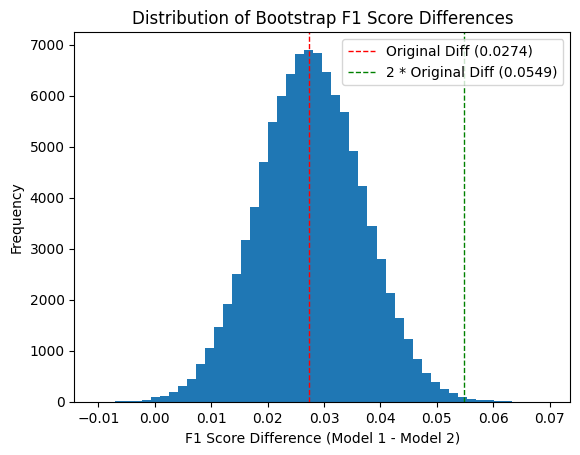

Calculated p-value: 0.00162


In [ ]:
model_A_name = "MuhammadHelmy/GATE-AraBert-AuthId"
model_B_name = "MuhammadHelmy/labse-Matryoshka-AuthId"

print(f"\nCalculated p-value: {get_p_value(model_A_name, model_B_name, test_dataset, 100000)}")

- We can see that the calculated p-value is very low, so, we can ignore the null hypothesis and accept that $A$ is indeed better than $B$.

Model 'MuhammadHelmy/GATE-AraBert-AuthId' loaded successfully!


Map:   0%|          | 0/4157 [00:00<?, ? examples/s]

/tmp/ipython-input-3989505319.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer)


tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Model 'MuhammadHelmy/xlm-roberta-base-arabic-AuthId' loaded successfully!


Map:   0%|          | 0/4157 [00:00<?, ? examples/s]

/tmp/ipython-input-3989505319.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer)


Original difference in F1 scores = 0.0020


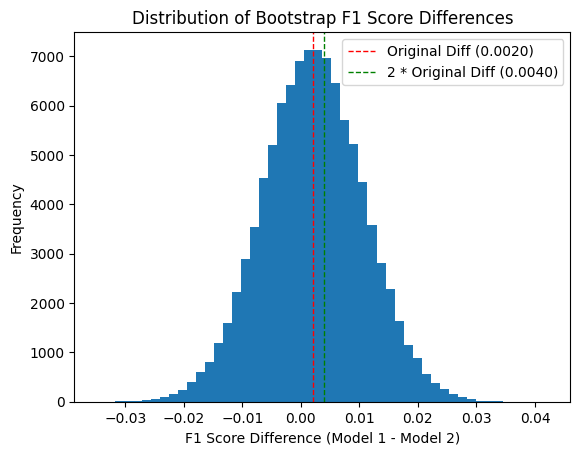

Calculated p-value: 0.41293


In [ ]:
model_A_name = "MuhammadHelmy/GATE-AraBert-AuthId"
model_B_name = "MuhammadHelmy/xlm-roberta-base-arabic-AuthId"

print(f"\nCalculated p-value: {get_p_value(model_A_name, model_B_name, test_dataset, 100000)}")

Model 'MuhammadHelmy/GATE-AraBert-AuthId' loaded successfully!


Map:   0%|          | 0/4157 [00:00<?, ? examples/s]

/tmp/ipython-input-3989505319.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Model 'batoulnn/camelbert_authorsclass3' loaded successfully!


Map:   0%|          | 0/4157 [00:00<?, ? examples/s]

/tmp/ipython-input-3989505319.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer)


Original difference in F1 scores = -0.0118


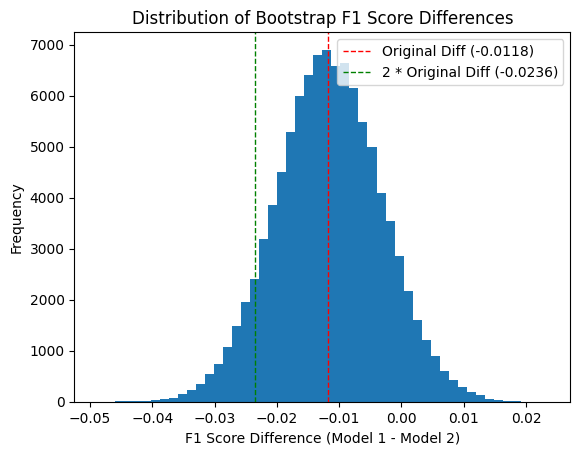

Calculated p-value: 0.92169


In [ ]:
model_A_name = "MuhammadHelmy/GATE-AraBert-AuthId"
model_B_name = "batoulnn/camelbert_authorsclass3"

print(f"\nCalculated p-value: {get_p_value(model_A_name, model_B_name, test_dataset, 100000)}")

# To do